# Desnity estimation with flows

**Goal:** I want to start playing with some alternate ways to do this background estimation, because it would be very nice to have a background estimation strategy that doesn't rely on 2b because
1. Using the 2b sample in our bkg derivation means we can't use the 3b triggers, which hurts our signal efficiency.
2. 

**Plan:** I'm going to start off using the 2b 2016 sample, and the same reweighting variables that Rafael and Sean are using for the NN reweighting to see if I can get the machinery working.

Then I'll look into reducing the stats to what I expect in 4b and see if the methodology still works.

If it does, then I can apply this method to 4b, and I think the interesting figure of merit here will be comparing the systematics, although we expect this systematic will decrease when I'm looking into new pairing algs that I have that have less sculpting in the massplane.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
#import uproot
from sklearn.preprocessing import StandardScaler

import os
import sys
sys.path.append("../../pytorch-flows")
import flows as fnn

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from scipy.stats import entropy, pearsonr, skew, kstest

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Step 1: Load in the data

In [3]:
sys.path.append("../code")
from AnalysisUtils import *

In [4]:
data_fileName = "../../public/hh4b/nanoNtuples/data16/data16_with_weights.root"
df = nanoToDf(data_fileName.format("topo"),ttree='fullmassplane')

fullmassplane


In [4]:
table = pd.DataFrame(0, index=['SB','CR','SR'], columns=['2b','3b','4b'])

In [5]:
for k,r in zip([2,1,0],['SB','CR','SR']):
    for b in [2,3,4]:
        c = f"{b}b"
        
        if b == 4:
            bmask = (df.ntag >= b) 
        else:
            bmask = (df.ntag == b)
        
        table.loc[r,c] = np.sum(bmask & (df.kinematic_region == k))

In [14]:
table

2b      3b    4b
SB  1560552  134750  9414
CR  1148017   96618  6688
SR  1077178       0     0

**Put it in the pytorch data loaders**

In [5]:
class hh4bDataset(Dataset):
    
    def __init__(self, myFile='', cols=['pT_h1','pT_h2'], 
                 cond_cols=[], log_cols = [], ntag=2, kinematic_region=None):
        """
        
        Inputs:
        - myFile: The name of the hdf5 file with the pandas Dataframe
        - cols: The input variables of interest
        
        """
        
        data_fileName = "../../public/hh4b/nanoNtuples/data16/data16_with_weights.root"
        df = nanoToDf(data_fileName.format("topo"),ttree='fullmassplane')
        
        # Select the requested # of b-tags and the kinematic region
        mask = (df.ntag == ntag)
        if not (kinematic_region is None):
            mask = mask & (df.kinematic_region == kinematic_region)
        df = df[mask]
        
        if 'njets' in cols:
            # Ok, so I decided that I'm going to use a one-hot encoding for the 
            # njets variables, with the largest bin for >= 10 jets
            maxNumJets = 10
            N = len(df.index)
            x_disc = np.zeros((N,maxNumJets-3))
            for i in range(4,maxNumJets+1):
                if i == maxNumJets:
                    mask = (df.njets >= i)
                else:
                    mask = (df.njets == i)
                x_disc[mask,i-4] = 1
        
        # It's hard to model this 40 GeV cut, so subtract 40 before taking the log
        df[[f'pT_{i}' for i in [2,4]]] -= 40 
        
        # Take the logarithm of variables that need to be positive   
        if len(log_cols) > 0:
            print("Taking the log of",log_cols)
            df[log_cols] = np.log(df[log_cols])
        
        scalarX = StandardScaler()
    
        # Here I'm assuming njets is the first element in the list
        cts_cols = [c for c in cols if c != 'njets']
        x_unnorm = df[cts_cols].values
        scalarX.fit(x_unnorm)
        x_cts = scalarX.transform(x_unnorm,copy=True)
        
        if 'njets' in cols:
            # Need to concatenate the discrete and continuous variables
            x = np.concatenate((x_disc,x_cts),axis=1)
        else:
            x = x_cts
        self.x = x
        self.scalarX = scalarX
        
        if len(cond_cols) > 0:
            
            y_unnorm = df[cond_cols].values
        
            scalarY = StandardScaler()
            scalarY.fit(y_unnorm)
            y = scalarY.transform(y_unnorm,copy=True)

            self.y = y
            self.scalarY = scalarY
            self.cond = True
                
        else:
            self.cond = False
        
        
    def __len__(self):
        return self.x.shape[0] 

    def __getitem__(self, idx):
        
        if self.cond:
            return self.x[idx], self.y[idx]
        else:
            return self.x[idx]


In [6]:
trainFrac = .4
valFrac = .1
testFrac = .5

N=1000

In [7]:
def getDataLoaders(myFile='', cols=['HC1_pT','HC2_pT'], 
                   cond_cols=[], log_cols=[], kinematic_region=None,
                   batch_size=1024, N=-1,returnScalar=False):
    '''
    Input: 
    - myFile: The name of the hdf5 file with the pandas Dataframe
    - cols: The input variables of interest
        -batch_size: default 128
    -N: Number of events to load in, the default value of -1  
 
    Returns: loader_train, loader_val, loader_test
        DataLoaders for the train, val, and test sets
 
    '''
        
    dset = hh4bDataset(myFile, cols, cond_cols,log_cols=log_cols,
                       kinematic_region=kinematic_region)
    if N != -1:
        nEvts = min(N, len(dset))
    else:
        nEvts = len(dset)
    print(nEvts)
        
    idxTrain = [j for j in range(int(trainFrac*nEvts))]
    idxVal   = [j for j in range(int(trainFrac*nEvts), int((trainFrac+valFrac)*nEvts))]
    idxTest  = [j for j in range(int((trainFrac+valFrac)*nEvts), nEvts)]
    
    loader_train = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(idxTrain))
    loader_val = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(idxVal))
    loader_test = DataLoader(dset, batch_size=batch_size, sampler=SubsetRandomSampler(idxTest))

    if len(cond_cols) > 0:
        scalars = dset.scalarX, dset.scalarY
    else:
        scalars = dset.scalarX
    
    if returnScalar:
        return loader_train, loader_val, loader_test, scalars
    else:
        return loader_train, loader_val, loader_test

In [7]:
#loader_train, loader_val, loader_test, scalar = getDataLoaders('myFile',N=N,returnScalar=True)

## Step 2: Set up a model

I ended up re-setting up model3 below.

## Step 3: Train the model

In [55]:
len(model_SB.loader_train)

32

In [57]:
for xi in model_SB.loader_train:
    break

In [60]:
xi.shape[0]

256

In [18]:
def train(epoch ,model, loader_train, device, optimizer):
    #global global_step
    model.train()
    
    train_loss = 0
    N = 0
    
    pbar = tqdm(total=len(loader_train))
    
    for batch_idx, data in enumerate(loader_train):

        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None
            data = data[0].float()
        else:
            data = data.float()
            cond_data = None
            
        data = data.to(device)
        optimizer.zero_grad()
        loss = -model.log_probs(data, cond_data).mean()
        
        ni = data.shape[0]
        train_loss += loss.item() * ni
        N += ni
        
        loss.backward()
        optimizer.step()

        pbar.update(data.size(0))
        pbar.set_description('Train, Log likelihood in nats: {:.6f}'.format(
            -train_loss / (batch_idx + 1)))
        
        #global_step += 1
        
    pbar.close()
    
    return(train_loss / N)
        

In [19]:
def validate(epoch, model, loader, device):
    #global global_step

    model.eval()
    val_loss = 0
    N = 0
    
    pbar = tqdm(total=len(loader))
    pbar.set_description('Eval')
    for data in loader:
        
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
                data = data[0].float()
            else:
                cond_data = None
                data = data.float()
        else:   
            data = data.float()
            cond_data=None
        
        data = data.to(device)
        with torch.no_grad():
            val_loss += -model.log_probs(data, cond_data).sum().item()
            N += data.shape[0]
                
        pbar.update(data.size(0))
        pbar.set_description('Val, Log likelihood in nats: {:.6f}'.format(
            -val_loss / pbar.n))

    pbar.close()
    return val_loss / N


**Question:** How do more input features help / hurt us?

From the generative models tutorial, they said something about the "bless of dimensionality", but I can't remember what the context was, and if it was for NFs or not?

## Conditional Density Estimation

**Goal:** Let's try to build a density estimator conditioned on *where* we are in the mass plane!

In [10]:
df.columns

Index(['run_number', 'event_number', 'mc_sf', 'ntag', 'njets',
       'kinematic_region', 'pairing_score_1', 'pairing_score_2', 'm_hh',
       'pt_hh', 'X_wt', 'm_h1', 'E_h1', 'pT_h1', 'eta_h1', 'phi_h1', 'm_h2',
       'E_h2', 'pT_h2', 'eta_h2', 'phi_h2', 'm_h1_j1', 'E_h1_j1', 'pT_h1_j1',
       'eta_h1_j1', 'phi_h1_j1', 'tag_h1_j1', 'angle_h1_j1', 'm_h1_j2',
       'E_h1_j2', 'pT_h1_j2', 'eta_h1_j2', 'phi_h1_j2', 'tag_h1_j2',
       'angle_h1_j2', 'm_h2_j1', 'E_h2_j1', 'pT_h2_j1', 'eta_h2_j1',
       'phi_h2_j1', 'tag_h2_j1', 'angle_h2_j1', 'm_h2_j2', 'E_h2_j2',
       'pT_h2_j2', 'eta_h2_j2', 'phi_h2_j2', 'tag_h2_j2', 'angle_h2_j2',
       'pT_4', 'pT_2', 'eta_i', 'dRjj_1', 'dRjj_2', 'BDT_d24_weight_16',
       'BDT_d24_weight_CRderiv_16'],
      dtype='object')

In [11]:
cols = ['njets','eta_i','pT_2','pT_4','dRjj_1','dRjj_2','pt_hh','m_hh']
# hc_cols = [f'{v}_h{i}' for v in ['pT','eta','phi'] for i in [1,2]]
cond_cols = [f'm_{h}' for h in ['h1','h2']]
loader_train3, loader_val3, loader_test3, (scalarX3, scalarY3) = \
    getDataLoaders('',cols=cols,cond_cols=cond_cols,log_cols=cols[1:],batch_size=256,N=57000*2,returnScalar=True)

fullmassplane
Taking the log of ['eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']
114000


In [12]:
np.sum((df.ntag>=4)&(df.kinematic_region>=2))

38288

In [13]:
128*4

512

In [14]:
device = 'cuda:2'

Ok, so I wanted to model the multinomial probabilities for the $n_{jets}$ distribution instead of modelling $n_{jets}$ directly, so this involves modifying the model and the associated loss function, so this is what I'm going to do below.

In [15]:
# x,cts = np.unique(df['njets'][:nTest],return_counts=True)
# cts / np.sum(cts)

In [23]:
maxNumJets=10

In [24]:
modules = []

num_inputs = (maxNumJets-4)+ len(cols)
num_hidden = 64
num_cond_inputs = len(cond_cols)
act = 'relu'

for _ in range(5):
        modules += [
            fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
            fnn.BatchNormFlow(num_inputs),
            fnn.Reverse(num_inputs)
        ]
               
model3 = fnn.FlowSequential(*modules)

for module in model3.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

model3.to(device)

optimizer = optim.Adam(model3.parameters(), lr=1e-4, weight_decay=1e-6)

In [25]:
best_validation_loss = float('inf')
best_validation_epoch = 0
best_model = model3
global_step = 0

nEpochs = 1
losses = {key: [] for key in ['train','val']}

for epoch in range(nEpochs):
    print('\nEpoch: {}'.format(epoch))

    train_loss = train(epoch, model3, loader_train3)
    losses['train'].append(train_loss)
    validation_loss = validate(epoch, model3, loader_val3)
    losses['val'].append(validation_loss)
    
    if epoch - best_validation_epoch >= 30:
        break

    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        torch.save(model3.state_dict(), "condDist.pt")

    print(
        'Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.
        format(best_validation_epoch, -best_validation_loss))

#model3.load_state_dict(torch.load("condDist.pt"))
    

  0%|          | 0/179 [00:00<?, ?it/s]


Epoch: 0
# batches 179


Train, Log likelihood in nats: 2.138000: : 45600it [00:05, 7602.95it/s] 
Val, Log likelihood in nats: nan: : 5888it [00:00, 28037.71it/s]

0 nan
1 nan
2 nan
3 nan
4 nan
5 nan
6 nan
7 nan
8 nan
9 nan
10 nan
11 nan
12 nan
13 nan
14 nan
15 nan
16 nan
17 nan
18 nan
19 nan
20 nan
21 nan
22 nan


Val, Log likelihood in nats: nan: : 11400it [00:00, 28758.92it/s]

23 nan
24 nan
25 nan
26 nan
27 nan
28 nan
29 nan
30 nan
31 nan
32 nan
33 nan
34 nan
35 nan
36 nan
37 nan
38 nan
39 nan
40 nan
41 nan
42 nan
43 nan
44 nan
Best validation at epoch 0: Average Log Likelihood in nats: -inf


In [26]:
losses

{'train': [-4.738270958545939e-05], 'val': [nan]}

Ok, clearly the model has overfit pretty badly, but this is good information for me to know already!!


Also, if I increase the batch size, it should train faster.

And, I should include $m_{hh}$ if this is the variable I want to model.

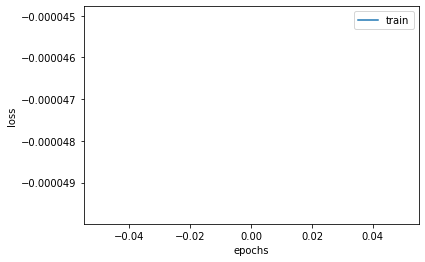

In [28]:
plt.plot(range(nEpochs),losses['train'],label='train')
#plt.plot(range(nEpochs),losses['val'],label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Maybe I need more regularization techniques?

**How do I evaluate the performance?** 

Plan: I will use the conditional $m_1$, $m_2$ from the validation set, and predict the distributions for the input variables, and compare against the imput distributions for the input dataset.

*Good news:* This is also what the `sample` function from FlowSequential expects!

In [57]:
np.min(df[[f'dRjj_{i}' for i in [1,2]]])

dRjj_1    0.142164
dRjj_2    0.398326
dtype: float64

In [29]:
ys = []
ss = []

for data in loader_test3:
        
    y = data[1].float()
    ys.append(y.cpu())
    
#     si = model3.sample(y.shape[0],cond_inputs=y) #.detach())
#     ss.append(si)
    
y = np.concatenate(ys)
y = torch.from_numpy(y).float()
# y = y.to(device)

In [59]:
len(cols[1:])

6

In [92]:
model3.to('cpu')

FlowSequential(
  (0): MADE(
    (joiner): MaskedLinear(
      (linear): Linear(in_features=14, out_features=64, bias=True)
      (cond_linear): Linear(in_features=2, out_features=64, bias=False)
    )
    (trunk): Sequential(
      (0): ReLU()
      (1): MaskedLinear(
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): ReLU()
      (3): MaskedLinear(
        (linear): Linear(in_features=64, out_features=28, bias=True)
      )
    )
  )
  (1): BatchNormFlow()
  (2): Reverse()
  (3): MADE(
    (joiner): MaskedLinear(
      (linear): Linear(in_features=14, out_features=64, bias=True)
      (cond_linear): Linear(in_features=2, out_features=64, bias=False)
    )
    (trunk): Sequential(
      (0): ReLU()
      (1): MaskedLinear(
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): ReLU()
      (3): MaskedLinear(
        (linear): Linear(in_features=64, out_features=28, bias=True)
      )
    )
  )
  (4): BatchNormFlow()

In [80]:
scalarX3.scale_

array([  0.3874602 ,  37.99985162,  12.29424464,   0.3416147 ,
         0.62203714,  58.28711919, 114.67314187])

In [79]:
cols

['njets', 'eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']

In [30]:
s = model3.sample(y.shape[0],cond_inputs=y.detach())
s = s.cpu().detach().numpy()
        
x_cts = scalarX3.inverse_transform(s[:,-7:])

# myMax = 1e10
# x_cts[x_cts > myMax] = myMax

x_cts = np.exp(x_cts)
x_cts[:,[1,2]] += 40

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [ ]:
nTest = s.shape[0]
nTest

In [ ]:
s.shape

In [ ]:
10.5-3.5

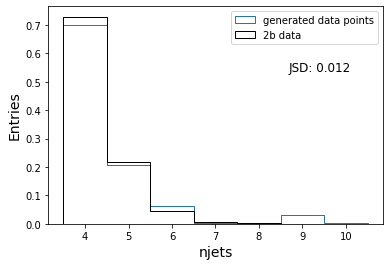

In [94]:
c='njets'
njets = 4+ np.argmax(s[:,:7],axis=1)

p, edg, _ = plt.hist([df[c][:nTest],njets],7,(3.5,10.5),
                     histtype='step',color=['k','C0'],
                     label=['2b data','generated data points'], density=True)

m = 0.5 * (p[1] + p[0])
JS = 0.5 * (entropy(p[1],m) + entropy(p[0],m))

xmax, ymax = plt.xlim()[1], plt.ylim()[1]

plt.text(0.8*xmax,0.7*ymax,'JSD: {:.3f}'.format(JS),fontsize=12)

plt.xlabel(c,fontsize=14)
plt.ylabel("Entries",fontsize=14)
plt.legend()
plt.show()

In [ ]:
x_cts.shape

I should put this logic in a single subfigure.

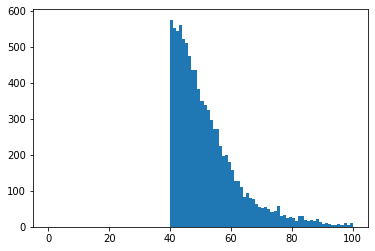

In [59]:
plt.hist(df['pT_4'][:nTest],100,(0,100))
plt.show()

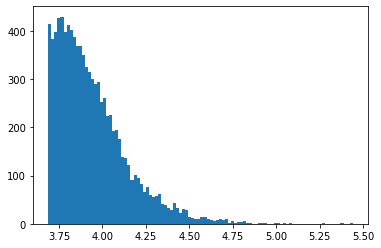

In [60]:
plt.hist(np.log(df['pT_4'][:nTest]),100)#,(0,100))
plt.show()

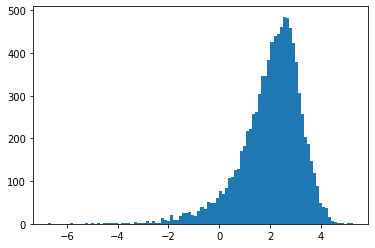

In [61]:
plt.hist(np.log(df['pT_4'][:nTest]-40),100)#,(0,100))
plt.show()

In [ ]:
hc_cols = [f'{v}_h{i}' for v in ['pT','eta','phi'] for i in [1,2]]
for v in ['pT','eta','phi']:
    for i in [1,2]:
        c= f'{v}_h{i}'
        plt.figure()
        plt.hist(df[c][:nTest],100)
        plt.xlabel(c)
plt.show()

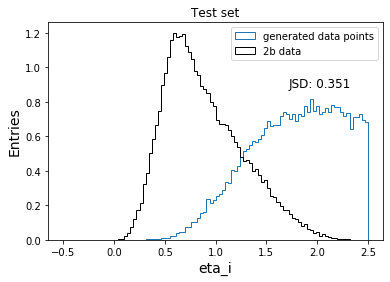

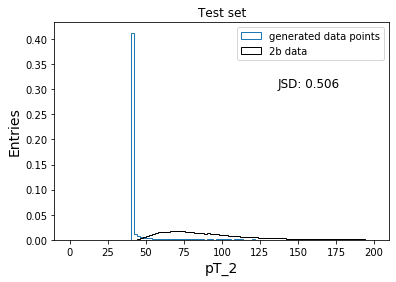

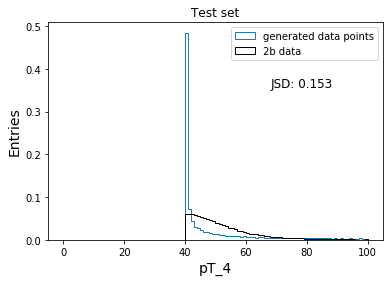

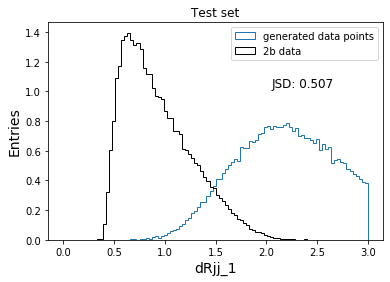

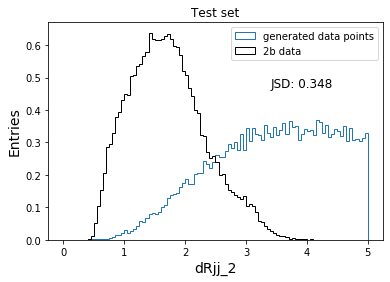

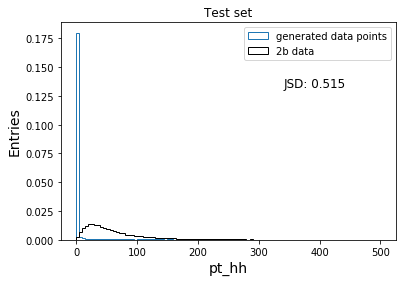

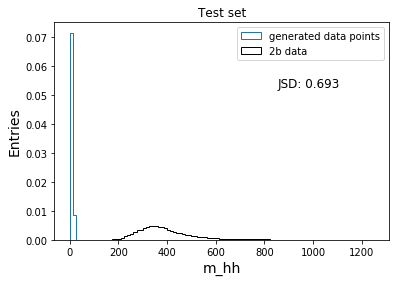

In [97]:
for i,c,r in zip(range(7),cols[1:],[(-.5,2.5),(0,200),(0,100),(0,3),(0,5),(0,500),(0,1250)]):
    
    plt.figure()

    p, edg, _ = plt.hist([df[c][:nTest],x_cts[:,i]],100,r,histtype='step',color=['k','C0'],
                         label=['2b data','generated data points'], density=True)

    m = 0.5 * (p[1] + p[0])
    JS = 0.5 * (entropy(p[1],m) + entropy(p[0],m))

    xmax, ymax = plt.xlim()[1], plt.ylim()[1]
    
    plt.text(0.65*xmax,0.7*ymax,'JSD: {:.3f}'.format(JS),fontsize=12)
    
    plt.xlabel(c,fontsize=14)
    plt.ylabel("Entries",fontsize=14)
    plt.legend()
    plt.title('Test set')
plt.show()



Ok, these distributions are *clearly* not such a good match, but I think I should make sure I understand the interplay b/w model complexity and # of training inputs before figuring out where to go from here.

**Woah** This is actually *really cool*!! 
- Taking the log of variables that need to be positive will ensure that I'm doing something reasonable here.
- Perhaps there could be a way for me to model the $n_{jets}$ dist better (like with a multinomial?) so that we're modelling a discrete probability distribution instead of a continuous one?

I could *also* see how it's depending based on the # of training variables...


### Unconditional density estimation

**Summary of the above studies**

Ok, so I think the models above were getting fucked up b/c the $n_{jets}$ variable is discrete, so shouldn't be naively plugged into these neural density estimators (for the MAF paper, they removed discrete variables from the datasets, or added a uniform noise).

But I think I might have also been trying to do too many steps at once, and maybe at first I should try an unconditional density estimator in the SB, and then check the extrapolation to see how close I am to reweighting model. 

I think the metric here will be the systematic from also deriving this model in the SB. I won't be able to do a comparison until I look at the 4b data, but this should be a good starting point!


In [21]:
class myMAF():
    
    def __init__(self,cols,nTest,nLayers=5,num_hidden=64):
    
        # Get the training dataset
        self.loader_train, self.loader_val, self.loader_test, scalars = \
            getDataLoaders('',cols=cols,log_cols=cols,batch_size=256,
                           N=nTest*2,returnScalar=True)

        self.scalarX = scalars
     
        # Get the model
        modules = []

        num_inputs = len(cols)
        num_cond_inputs = None
        act = 'relu'
        
        for _ in range(nLayers):
            modules += [
                fnn.MADE(num_inputs, num_hidden, num_cond_inputs, act=act),
                fnn.BatchNormFlow(num_inputs),
                fnn.Reverse(num_inputs)
            ]

        self.model = fnn.FlowSequential(*modules)

        # Initialize the weights
        for module in self.model.modules():
            if isinstance(module, nn.Linear):
                nn.init.orthogonal_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    module.bias.data.fill_(0)

        
        # Define the training metrics
        self.losses = {key: [] for key in ['train','val']}
        
    def train(self,nEpochs=2, lr=1e-4, weight_decay=1e-6, device='cuda:2'):
        
        # Define the optimizer
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.model.to(device)
        
        # Train the model
        best_validation_loss = float('inf')
        best_validation_epoch = 0
        best_model = self.model
        
        nEpochs = 2

        for epoch in range(nEpochs):
            print('\nEpoch: {}'.format(epoch))

            train_loss = train(epoch, self.model, self.loader_train,device,optimizer)
            self.losses['train'].append(train_loss)
            validation_loss = validate(epoch, self.model, self.loader_val,device)
            self.losses['val'].append(validation_loss)

            if validation_loss < best_validation_loss:
                best_validation_epoch = epoch
                best_validation_loss = validation_loss
                best_model = self.model
                #torch.save(model_SB.state_dict(), "condDist.pt")

            print(
                'Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.
                format(best_validation_epoch, -best_validation_loss))
            
        # Load the best model back into self.model at this point
        self.model = best_model

In [84]:
# Load in the data
nTest = 10000
cols = ['eta_i','pT_2','pT_4','dRjj_1','dRjj_2','pt_hh','m_hh']

model_SB = myMAF(cols,nTest)


fullmassplane
Taking the log of ['eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']
20000


In [85]:
# Train it
nEpochs = 2
model_SB.train(nEpochs)



  0%|          | 0/32 [00:00<?, ?it/s]

Train, Log likelihood in nats: -2549.814209: : 256it [00:00, 8089.18it/s]

Train, Log likelihood in nats: -2557.225952: : 512it [00:00, 8426.10it/s]

Train, Log likelihood in nats: -2541.948975: : 768it [00:00, 8723.32it/s]

Train, Log likelihood in nats: -2541.948975: : 1024it [00:00, 9013.21it/s]

Train, Log likelihood in nats: -2546.521423: : 1024it [00:00, 9013.21it/s]

Train, Log likelihood in nats: -2531.718799: : 1280it [00:00, 9013.21it/s]


Epoch: 0




Train, Log likelihood in nats: -2538.390584: : 1536it [00:00, 9013.21it/s]

Train, Log likelihood in nats: -2536.834229: : 1792it [00:00, 9013.21it/s]

Train, Log likelihood in nats: -2536.834229: : 2048it [00:00, 9339.96it/s]

Train, Log likelihood in nats: -2534.457245: : 2048it [00:00, 9339.96it/s]

Train, Log likelihood in nats: -2534.540988: : 2304it [00:00, 9339.96it/s]

Train, Log likelihood in nats: -2531.484155: : 2560it [00:00, 9339.96it/s]

Train, Log likelihood in nats: -2531.086892: : 2816it [00:00, 9339.96it/s]

Train, Log likelihood in nats: -2531.086892: : 3072it [00:00, 9516.67it/s]

Train, Log likelihood in nats: -2542.797953: : 3072it [00:00, 9516.67it/s]

Train, Log likelihood in nats: -2538.920936: : 3328it [00:00, 9516.67it/s]

Train, Log likelihood in nats: -2537.869803: : 3584it [00:00, 9516.67it/s]

Train, Log likelihood in nats: -2537.869803: : 3840it [00:00, 8173.60it/s]

Train, Log likelihood in nats: -2537.892969: : 3840it [00:00, 8173.60it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -9.9847

Epoch: 1




Train, Log likelihood in nats: -2530.493164: : 1536it [00:00, 6874.64it/s]

Train, Log likelihood in nats: -2527.459025: : 1536it [00:00, 6874.64it/s]

Train, Log likelihood in nats: -2538.060442: : 1792it [00:00, 6874.64it/s]

Train, Log likelihood in nats: -2534.360260: : 2048it [00:00, 6874.64it/s]

Train, Log likelihood in nats: -2534.360260: : 2304it [00:00, 6905.72it/s]

Train, Log likelihood in nats: -2534.766249: : 2304it [00:00, 6905.72it/s]

Train, Log likelihood in nats: -2535.382471: : 2560it [00:00, 6905.72it/s]

Train, Log likelihood in nats: -2535.065807: : 2816it [00:00, 6905.72it/s]

Train, Log likelihood in nats: -2535.065807: : 3072it [00:00, 7085.68it/s]

Train, Log likelihood in nats: -2535.701294: : 3072it [00:00, 7085.68it/s]

Train, Log likelihood in nats: -2535.509615: : 3328it [00:00, 7085.68it/s]

Train, Log likelihood in nats: -2537.132952: : 3584it [00:00, 7085.68it/s]

Train, Log likelihood in nats: -2537.132952: : 3840it [00:00, 7054.02it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -9.9847


In [86]:
model_SB.losses

{'train': [9.932611320495605, 9.927368576049805],
 'val': [9.984685485839844, 10.02915087890625]}

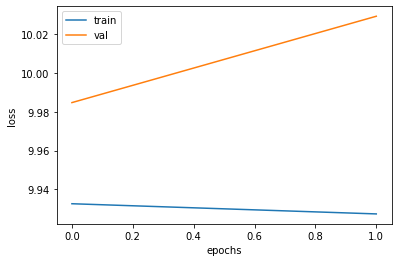

In [87]:
plt.plot(range(nEpochs),model_SB.losses['train'],label='train')
plt.plot(range(nEpochs),model_SB.losses['val'],label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Doing multiple passes over the data doesn't help, that probably means the training dataset is large enough (but I'm not 100% sure).

In [27]:
myRanges = {
    'eta_i' : (-.5,2.5),
    'pT_2'  : (0,200),
    'pT_4'  : (0,100),
    'dRjj_1': (0,3),
    'dRjj_2': (0,5),
    'pt_hh' : (0,500),
    'm_hh'  : (0,1250)
}

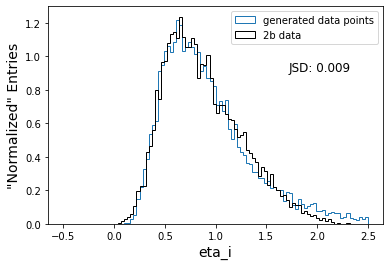

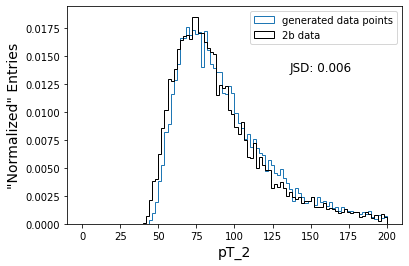

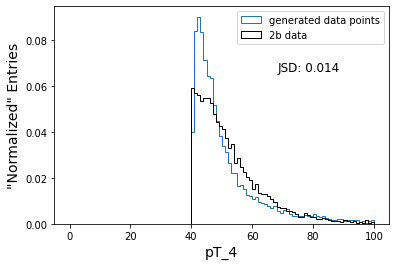

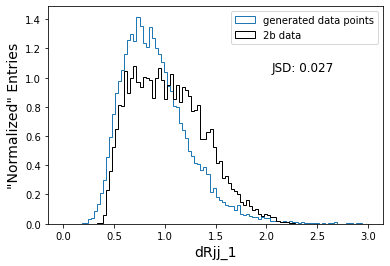

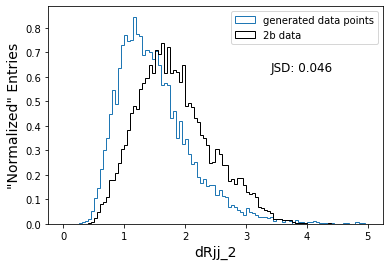

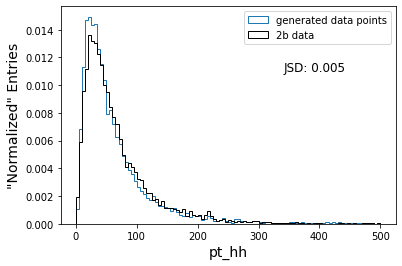

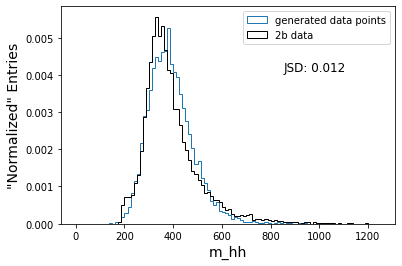

In [88]:
s = model_SB.model.sample(nTest).cpu().detach().numpy()
s = model_SB.scalarX.inverse_transform(s)

# Since I was modelling the log of these variables, I
# need to exponentiate to get back to the real space
s = np.exp(s)

# Add 40 to the first pT_2 and
for i,c in enumerate(cols):
    if (c == 'pT_2') or (c == 'pT_4'):
        s[:,i] += 40

mask = (df.ntag==2) & (df.kinematic_region==2)
for i,c in enumerate(cols):

    plt.figure()

    p, edg, _ = plt.hist([df.loc[mask,c].values[nTest:2*nTest],s[:,i]],
                         100,myRanges[c],histtype='step',color=['k','C0'],
                         label=['2b data','generated data points'], density=True)

    m = 0.5 * (p[1] + p[0])
    JS = 0.5 * (entropy(p[1],m) + entropy(p[0],m))

    xmax, ymax = plt.xlim()[1], plt.ylim()[1]

    plt.text(0.65*xmax,0.7*ymax,'JSD: {:.3f}'.format(JS),fontsize=12)

    plt.xlabel(c,fontsize=14)
    plt.ylabel('"Normalized" Entries',fontsize=14)
    plt.legend()
    #plt.title('Test set')

# Save the figure
plt.show()


The background estimate is *more peaked* than we might have expected, and it seems different enough that it could have a sizable impact on our limits.


**Where might we be limited?**
- Size of the training dataset
- Hyperparameter scan (They didn't try that many models in the paper)
- Ordering for the input dimensions
- Not enough regularization (could try dialing up the weight decay). The reason why I thought why this might be the issue is b/c the training loss is quite a bit higher than the testing loss.
- Is the modelling better just for $m_{hh}$ when I include more or fewer features in the training? (I feel like this c
- Model architecture - could try MADE with a MOG? I feel like there was something in the paper that suggested that this might be better for lower dimensional joints. Also, I could try a non-affine flow, i.e, a neural autoregressive flow, since I don't need to sample from it?


### Training dataset size

In [83]:
myModels = [model_SB]
trainingSize = [10000, 50000,250000]

for nTest in trainingSize[1:]:
    
    model = myMAF(cols,nTest)
    
    model.train(nEpochs)
    
    myModels.append(model)

fullmassplane


KeyboardInterrupt: 

Compare the training and validation log likelihoods

In [82]:
for m in myModels:
    print(m.losses)

{'train': [4.0095277378270534e-05, 4.0087198072248406e-05], 'val': [0.0025454248851622197, 0.002541211744979743]}
{'train': [0.00019307322945927166, 0.00019307125559359727], 'val': [0.012404244021857382, 0.01243724403509379]}
{'train': [0.0009563846600915242, 0.0009564315659977648], 'val': [0.06260358000695207, 0.062256067278302976]}


Ok, since the loss is getting *bigger* as we add more training data, this means we need to *increase the model capacity*.

Let's make a pretty plot for this!

Compare the distributions

In [64]:
nTest

250000

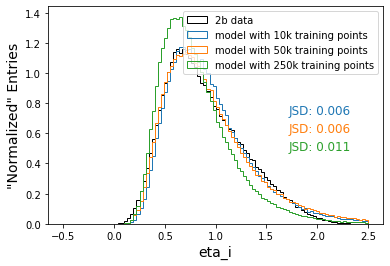

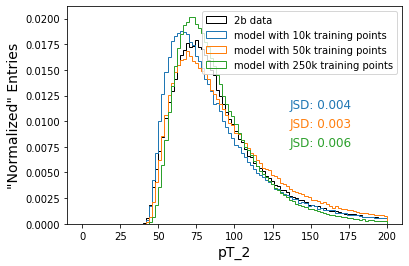

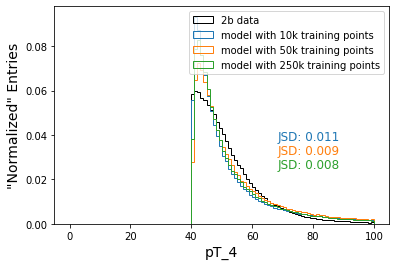

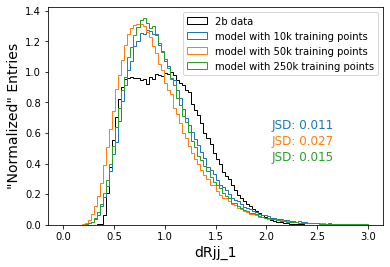

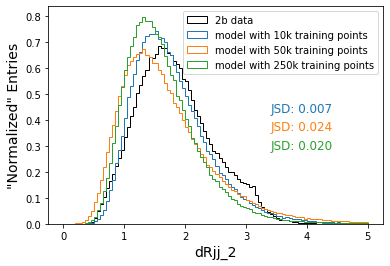

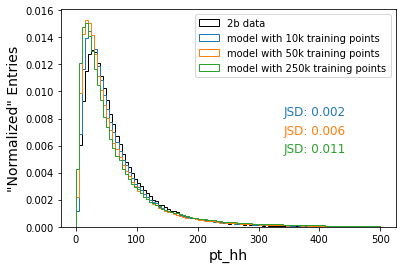

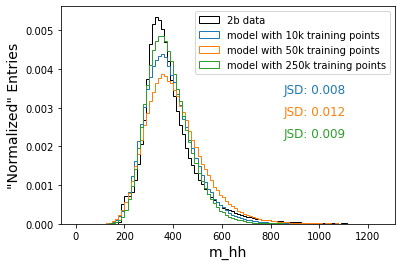

In [69]:
# Loop through the training dataset sizes and get the predictions from the generated model
ss = []
for model in myModels:
    s = model.model.sample(nTest).cpu().detach().numpy()
    s = model.scalarX.inverse_transform(s)

    # Since I was modelling the log of these variables, I
    # need to exponentiate to get back to the real space
    s = np.exp(s)

    # Add 40 to the first pT_2 and
    for i,c in enumerate(cols):
        if (c == 'pT_2') or (c == 'pT_4'):
            s[:,i] += 40

    ss.append(s)
            
mask = (df.ntag==2) & (df.kinematic_region==2)
for i,c in enumerate(cols):

    plt.figure()

    # Put the 2b data on the plot
    p0,_,_ = plt.hist(df.loc[mask,c].values[nTest:2*nTest],
                         100,myRanges[c],histtype='step',color='k',
                         label='2b data', density=True)

    xmax, ymax = plt.xlim()[1], plt.ylim()[1]
    
    
    # Put the trained models on the plot
    for s,color,nTrain,yrel in zip(ss,['C0','C1','C2'],['10k','50k','250k'],[.6,.5,.4]):
        p1,_,_ = plt.hist(s[:,i],100,myRanges[c],histtype='step',color=color,
                        label=f'model with {nTrain} training points', density=True)

        # Calc the JSD
        m = 0.5 * (p1 + p0)
        JS = 0.5 * (entropy(p1,m) + entropy(p0,m))
    
        text = 'JSD: {:.3f}'.format(JS)
        plt.text(0.65*xmax,yrel*ymax,text,fontsize=12,color=color)

    plt.xlabel(c,fontsize=14)
    plt.ylabel('"Normalized" Entries',fontsize=14)
    plt.legend()
    #plt.title('Test set')

# Save the figure

plt.show()



### Hyperparameters

Ok, so it seems like the message from the above plots is that increasing the training dataset size isn't really helping with our model's performance, so instead I'm going to try increasing with the model's capacity.

In [72]:
[1,2]*3

[1, 2, 1, 2, 1, 2]

[[64, 64], [128, 128], [256, 256]]

In [90]:
hyperparams = []
nTest = 10000

for num_hidden in [64,128,256,512]:
    
    model = myMAF(cols,nTest,num_hidden=num_hidden)
    model.train(nEpochs)
    hyperparams.append(model)

fullmassplane
Taking the log of ['eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']




  0%|          | 0/32 [00:00<?, ?it/s]

Train, Log likelihood in nats: -2495.328369: : 256it [00:00, 8450.47it/s]

Train, Log likelihood in nats: -2486.942993: : 512it [00:00, 8600.05it/s]

Train, Log likelihood in nats: -2521.996501: : 768it [00:00, 8740.50it/s]

Train, Log likelihood in nats: -2521.996501: : 1024it [00:00, 8827.25it/s]

Train, Log likelihood in nats: -2520.136841: : 1024it [00:00, 8827.25it/s]

Train, Log likelihood in nats: -2528.931445: : 1280it [00:00, 8827.25it/s]

20000

Epoch: 0




Train, Log likelihood in nats: -2537.940999: : 1536it [00:00, 8827.25it/s]

Train, Log likelihood in nats: -2528.982910: : 1792it [00:00, 8827.25it/s]

Train, Log likelihood in nats: -2528.982910: : 2048it [00:00, 8843.86it/s]

Train, Log likelihood in nats: -2529.840210: : 2048it [00:00, 8843.86it/s]

Train, Log likelihood in nats: -2524.869683: : 2304it [00:00, 8843.86it/s]

Train, Log likelihood in nats: -2524.008887: : 2560it [00:00, 8843.86it/s]

Train, Log likelihood in nats: -2523.592219: : 2816it [00:00, 8843.86it/s]

Train, Log likelihood in nats: -2523.592219: : 3072it [00:00, 8778.07it/s]

Train, Log likelihood in nats: -2524.672933: : 3072it [00:00, 8778.07it/s]

Train, Log likelihood in nats: -2521.858812: : 3328it [00:00, 8778.07it/s]

Train, Log likelihood in nats: -2521.874372: : 3584it [00:00, 8778.07it/s]

Train, Log likelihood in nats: -2524.499219: : 3840it [00:00, 8778.07it/s]

Train, Log likelihood in nats: -2524.499219: : 4096it [00:00, 8966.11it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -9.9916

Epoch: 1




Train, Log likelihood in nats: -2557.914760: : 1792it [00:00, 8837.33it/s]

Train, Log likelihood in nats: -2557.914760: : 2048it [00:00, 8586.44it/s]

Train, Log likelihood in nats: -2554.305725: : 2048it [00:00, 8586.44it/s]

Train, Log likelihood in nats: -2555.125326: : 2304it [00:00, 8586.44it/s]

Train, Log likelihood in nats: -2555.033813: : 2560it [00:00, 8586.44it/s]

Train, Log likelihood in nats: -2545.857866: : 2816it [00:00, 8586.44it/s]

Train, Log likelihood in nats: -2545.857866: : 3072it [00:00, 8558.16it/s]

Train, Log likelihood in nats: -2544.645264: : 3072it [00:00, 8558.16it/s]

Train, Log likelihood in nats: -2541.393742: : 3328it [00:00, 8558.16it/s]

Train, Log likelihood in nats: -2540.261841: : 3584it [00:00, 8558.16it/s]

Train, Log likelihood in nats: -2542.079215: : 3840it [00:00, 8558.16it/s]

Train, Log likelihood in nats: -2542.079215: : 4096it [00:00, 8422.92it/s]

Train, Log likelihood in nats: -2541.734634: : 4096it [00:00, 8422.92it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -9.9916
fullmassplane
Taking the log of ['eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']




  0%|          | 0/32 [00:00<?, ?it/s]

Train, Log likelihood in nats: -2545.836914: : 256it [00:00, 8188.25it/s]

Train, Log likelihood in nats: -2586.280396: : 512it [00:00, 8241.99it/s]

Train, Log likelihood in nats: -2553.549561: : 768it [00:00, 8216.70it/s]

Train, Log likelihood in nats: -2553.549561: : 1024it [00:00, 8297.14it/s]

Train, Log likelihood in nats: -2550.548401: : 1024it [00:00, 8297.14it/s]

Train, Log likelihood in nats: -2549.342627: : 1280it [00:00, 8297.14it/s]

20000

Epoch: 0




Train, Log likelihood in nats: -2544.674520: : 1536it [00:00, 8297.14it/s]

Train, Log likelihood in nats: -2541.959926: : 1792it [00:00, 8297.14it/s]

Train, Log likelihood in nats: -2541.959926: : 2048it [00:00, 8280.69it/s]

Train, Log likelihood in nats: -2547.651154: : 2048it [00:00, 8280.69it/s]

Train, Log likelihood in nats: -2548.870063: : 2304it [00:00, 8280.69it/s]

Train, Log likelihood in nats: -2548.763867: : 2560it [00:00, 8280.69it/s]

Train, Log likelihood in nats: -2550.634632: : 2816it [00:00, 8280.69it/s]

Train, Log likelihood in nats: -2550.634632: : 3072it [00:00, 8271.78it/s]

Train, Log likelihood in nats: -2554.238342: : 3072it [00:00, 8271.78it/s]

Train, Log likelihood in nats: -2552.863601: : 3328it [00:00, 8271.78it/s]

Train, Log likelihood in nats: -2551.108398: : 3584it [00:00, 8271.78it/s]

Train, Log likelihood in nats: -2552.969596: : 3840it [00:00, 8271.78it/s]

Train, Log likelihood in nats: -2552.969596: : 4096it [00:00, 8288.00it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -10.0889

Epoch: 1




Train, Log likelihood in nats: -2553.366629: : 1792it [00:00, 8490.70it/s]

Train, Log likelihood in nats: -2553.366629: : 2048it [00:00, 8440.98it/s]

Train, Log likelihood in nats: -2547.991669: : 2048it [00:00, 8440.98it/s]

Train, Log likelihood in nats: -2554.466634: : 2304it [00:00, 8440.98it/s]

Train, Log likelihood in nats: -2554.143213: : 2560it [00:00, 8440.98it/s]

Train, Log likelihood in nats: -2560.680309: : 2816it [00:00, 8440.98it/s]

Train, Log likelihood in nats: -2560.680309: : 3072it [00:00, 8470.04it/s]

Train, Log likelihood in nats: -2561.828023: : 3072it [00:00, 8470.04it/s]

Train, Log likelihood in nats: -2560.766808: : 3328it [00:00, 8470.04it/s]

Train, Log likelihood in nats: -2559.530535: : 3584it [00:00, 8470.04it/s]

Train, Log likelihood in nats: -2560.658089: : 3840it [00:00, 8470.04it/s]

Train, Log likelihood in nats: -2560.658089: : 4096it [00:00, 8677.06it/s]

Train, Log likelihood in nats: -2557.415771: : 4096it [00:00, 8677.06it/s]

Train, Log

Best validation at epoch 1: Average Log Likelihood in nats: -9.9989
fullmassplane
Taking the log of ['eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']




  0%|          | 0/32 [00:00<?, ?it/s]

Train, Log likelihood in nats: -2571.236816: : 256it [00:00, 7764.42it/s]

Train, Log likelihood in nats: -2519.666016: : 512it [00:00, 8006.01it/s]

Train, Log likelihood in nats: -2528.621094: : 768it [00:00, 8211.92it/s]

Train, Log likelihood in nats: -2528.621094: : 1024it [00:00, 8382.60it/s]

Train, Log likelihood in nats: -2535.261536: : 1024it [00:00, 8382.60it/s]

20000

Epoch: 0




Train, Log likelihood in nats: -2546.333545: : 1280it [00:00, 8382.60it/s]

Train, Log likelihood in nats: -2544.882121: : 1536it [00:00, 8382.60it/s]

Train, Log likelihood in nats: -2536.891567: : 1792it [00:00, 8382.60it/s]

Train, Log likelihood in nats: -2536.891567: : 2048it [00:00, 8475.72it/s]

Train, Log likelihood in nats: -2532.185394: : 2048it [00:00, 8475.72it/s]

Train, Log likelihood in nats: -2537.098280: : 2304it [00:00, 8475.72it/s]

Train, Log likelihood in nats: -2534.862866: : 2560it [00:00, 8475.72it/s]

Train, Log likelihood in nats: -2539.104781: : 2816it [00:00, 8475.72it/s]

Train, Log likelihood in nats: -2539.104781: : 3072it [00:00, 8464.15it/s]

Train, Log likelihood in nats: -2547.661825: : 3072it [00:00, 8464.15it/s]

Train, Log likelihood in nats: -2551.276780: : 3328it [00:00, 8464.15it/s]

Train, Log likelihood in nats: -2553.387713: : 3584it [00:00, 8464.15it/s]

Train, Log likelihood in nats: -2558.736963: : 3840it [00:00, 8464.15it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -10.2024

Epoch: 1




Train, Log likelihood in nats: -2551.056222: : 1792it [00:00, 9031.54it/s]

Train, Log likelihood in nats: -2551.056222: : 2048it [00:00, 8852.73it/s]

Train, Log likelihood in nats: -2549.665894: : 2048it [00:00, 8852.73it/s]

Train, Log likelihood in nats: -2552.345296: : 2304it [00:00, 8852.73it/s]

Train, Log likelihood in nats: -2549.209302: : 2560it [00:00, 8852.73it/s]

Train, Log likelihood in nats: -2551.443959: : 2816it [00:00, 8852.73it/s]

Train, Log likelihood in nats: -2551.443959: : 3072it [00:00, 8943.37it/s]

Train, Log likelihood in nats: -2553.268982: : 3072it [00:00, 8943.37it/s]

Train, Log likelihood in nats: -2555.560829: : 3328it [00:00, 8943.37it/s]

Train, Log likelihood in nats: -2556.845337: : 3584it [00:00, 8943.37it/s]

Train, Log likelihood in nats: -2552.179492: : 3840it [00:00, 8943.37it/s]

Train, Log likelihood in nats: -2552.179492: : 4096it [00:00, 9024.67it/s]

Train, Log likelihood in nats: -2551.570465: : 4096it [00:00, 9024.67it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -10.2024
fullmassplane
Taking the log of ['eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']




  0%|          | 0/32 [00:00<?, ?it/s]

Train, Log likelihood in nats: -2550.737305: : 256it [00:00, 5805.45it/s]

Train, Log likelihood in nats: -2554.951904: : 512it [00:00, 5998.99it/s]

20000

Epoch: 0




Train, Log likelihood in nats: -2554.951904: : 768it [00:00, 6391.76it/s]

Train, Log likelihood in nats: -2547.469076: : 768it [00:00, 6391.76it/s]

Train, Log likelihood in nats: -2563.256714: : 1024it [00:00, 6391.76it/s]

Train, Log likelihood in nats: -2564.842480: : 1280it [00:00, 6391.76it/s]

Train, Log likelihood in nats: -2563.633016: : 1536it [00:00, 6391.76it/s]

Train, Log likelihood in nats: -2563.633016: : 1792it [00:00, 6838.71it/s]

Train, Log likelihood in nats: -2564.123989: : 1792it [00:00, 6838.71it/s]

Train, Log likelihood in nats: -2554.598267: : 2048it [00:00, 6838.71it/s]

Train, Log likelihood in nats: -2547.754557: : 2304it [00:00, 6838.71it/s]

Train, Log likelihood in nats: -2547.013892: : 2560it [00:00, 6838.71it/s]

Train, Log likelihood in nats: -2547.013892: : 2816it [00:00, 7330.49it/s]

Train, Log likelihood in nats: -2545.414196: : 2816it [00:00, 7330.49it/s]

Train, Log likelihood in nats: -2543.368449: : 3072it [00:00, 7330.49it/s]

Train, Log l

Best validation at epoch 0: Average Log Likelihood in nats: -10.2247

Epoch: 1




Train, Log likelihood in nats: -2533.704520: : 1792it [00:00, 8099.52it/s]

Train, Log likelihood in nats: -2533.704520: : 2048it [00:00, 8390.10it/s]

Train, Log likelihood in nats: -2540.630646: : 2048it [00:00, 8390.10it/s]

Train, Log likelihood in nats: -2536.289741: : 2304it [00:00, 8390.10it/s]

Train, Log likelihood in nats: -2540.336548: : 2560it [00:00, 8390.10it/s]

Train, Log likelihood in nats: -2541.398371: : 2816it [00:00, 8390.10it/s]

Train, Log likelihood in nats: -2541.398371: : 3072it [00:00, 8686.95it/s]

Train, Log likelihood in nats: -2545.432678: : 3072it [00:00, 8686.95it/s]

Train, Log likelihood in nats: -2545.451303: : 3328it [00:00, 8686.95it/s]

Train, Log likelihood in nats: -2545.320068: : 3584it [00:00, 8686.95it/s]

Train, Log likelihood in nats: -2548.475586: : 3840it [00:00, 8686.95it/s]

Train, Log likelihood in nats: -2548.475586: : 4096it [00:00, 8891.19it/s]

Train, Log likelihood in nats: -2552.437073: : 4096it [00:00, 8891.19it/s]

Train, Log

Best validation at epoch 1: Average Log Likelihood in nats: -10.0534


In [91]:
for m in hyperparams:
    print(m.losses)

{'train': [9.890062850952148, 9.887429450988769], 'val': [9.99163311767578, 10.03685546875]}
{'train': [9.956680160522462, 9.953978355407715], 'val': [10.088922729492188, 9.998947631835938]}
{'train': [9.983776184082032, 9.981444770812988], 'val': [10.2024365234375, 10.269216186523437]}
{'train': [9.974811912536621, 9.976624969482423], 'val': [10.224732177734374, 10.05337158203125]}


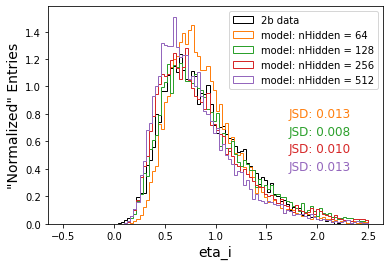

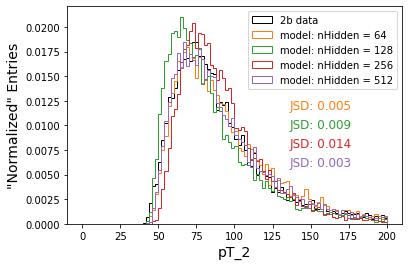

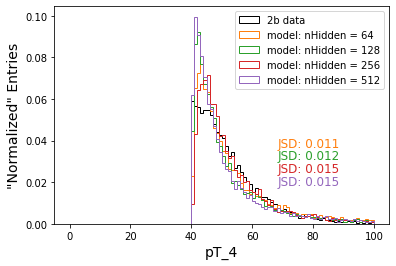

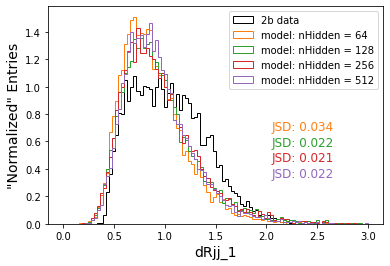

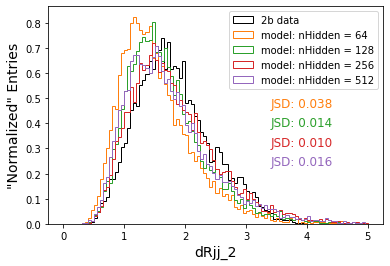

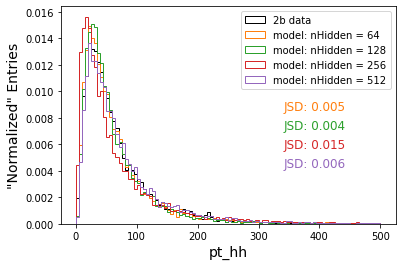

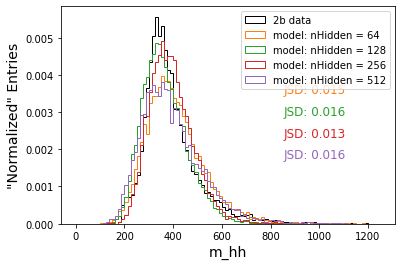

In [92]:
# Loop through the training dataset sizes and get the predictions from the generated model
ss = []
for m in hyperparams:
    s = m.model.sample(nTest).cpu().detach().numpy()
    s = m.scalarX.inverse_transform(s)

    # Since I was modelling the log of these variables, I
    # need to exponentiate to get back to the real space
    s = np.exp(s)

    # Add 40 to the first pT_2 and
    for i,c in enumerate(cols):
        if (c == 'pT_2') or (c == 'pT_4'):
            s[:,i] += 40

    ss.append(s)
            
mask = (df.ntag==2) & (df.kinematic_region==2)
for i,c in enumerate(cols):

    plt.figure()

    # Put the 2b data on the plot
    p0,_,_ = plt.hist(df.loc[mask,c].values[nTest:2*nTest],
                      100,myRanges[c],histtype='step',color='k',
                      label='2b data', density=True)

    xmax, ymax = plt.xlim()[1], plt.ylim()[1]
    
    # Put the trained models on the plot
    for s,color,num_hidden,yrel in zip(ss,['C1','C2','C3','C4'],[64,128,256,512],[.6,.5,.4,.3]):
        p1,_,_ = plt.hist(s[:,i],100,myRanges[c],histtype='step',color=color,
                        label=f'model: nHidden = {num_hidden}', density=True)

        # Calc the JSD
        m = 0.5 * (p1 + p0)
        JS = 0.5 * (entropy(p1,m) + entropy(p0,m))
    
        text = 'JSD: {:.3f}'.format(JS)
        plt.text(0.65*xmax,yrel*ymax,text,fontsize=12,color=color)

    plt.xlabel(c,fontsize=14)
    plt.ylabel('"Normalized" Entries',fontsize=14)
    plt.legend()
    #plt.title('Test set')

# Save the figure

plt.show()




It doesn't seem like these more complex models are performing significantly better tbh.

Ok, tomorrow, I think I'm going to replace the JSD with the KL divergence, b/c I think that's what I really want.

### Ordering

### Increasing the L2 regularization

In [100]:
L2_reg = [model_SB]
betas = [1e-6,1e-5,1e-4]

for weight_decay in betas[1:]:
    
    model = myMAF(cols,nTest)
    model.train(nEpochs,weight_decay=weight_decay)
    L2_reg.append(model)

fullmassplane
Taking the log of ['eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']




  0%|          | 0/32 [00:00<?, ?it/s]

Train, Log likelihood in nats: -2457.258789: : 256it [00:00, 8446.41it/s]

Train, Log likelihood in nats: -2526.046875: : 512it [00:00, 8523.79it/s]

Train, Log likelihood in nats: -2533.246012: : 768it [00:00, 8621.92it/s]

Train, Log likelihood in nats: -2533.246012: : 1024it [00:00, 8717.03it/s]

Train, Log likelihood in nats: -2542.724976: : 1024it [00:00, 8717.03it/s]

20000

Epoch: 0




Train, Log likelihood in nats: -2558.425635: : 1280it [00:00, 8717.03it/s]

Train, Log likelihood in nats: -2545.118205: : 1536it [00:00, 8717.03it/s]

Train, Log likelihood in nats: -2543.402623: : 1792it [00:00, 8717.03it/s]

Train, Log likelihood in nats: -2543.402623: : 2048it [00:00, 8626.27it/s]

Train, Log likelihood in nats: -2542.369690: : 2048it [00:00, 8626.27it/s]

Train, Log likelihood in nats: -2548.097005: : 2304it [00:00, 8626.27it/s]

Train, Log likelihood in nats: -2546.514404: : 2560it [00:00, 8626.27it/s]

Train, Log likelihood in nats: -2546.954945: : 2816it [00:00, 8626.27it/s]

Train, Log likelihood in nats: -2546.954945: : 3072it [00:00, 8495.46it/s]

Train, Log likelihood in nats: -2551.378418: : 3072it [00:00, 8495.46it/s]

Train, Log likelihood in nats: -2550.062200: : 3328it [00:00, 8495.46it/s]

Train, Log likelihood in nats: -2552.454694: : 3584it [00:00, 8495.46it/s]

Train, Log likelihood in nats: -2551.005273: : 3840it [00:00, 8495.46it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -10.1076

Epoch: 1




Train, Log likelihood in nats: -2545.483573: : 1792it [00:00, 8449.27it/s]

Train, Log likelihood in nats: -2545.483573: : 2048it [00:00, 8462.99it/s]

Train, Log likelihood in nats: -2549.677826: : 2048it [00:00, 8462.99it/s]

Train, Log likelihood in nats: -2543.329373: : 2304it [00:00, 8462.99it/s]

Train, Log likelihood in nats: -2533.048340: : 2560it [00:00, 8462.99it/s]

Train, Log likelihood in nats: -2535.169145: : 2816it [00:00, 8462.99it/s]

Train, Log likelihood in nats: -2535.169145: : 3072it [00:00, 8380.42it/s]

Train, Log likelihood in nats: -2545.357788: : 3072it [00:00, 8380.42it/s]

Train, Log likelihood in nats: -2544.839262: : 3328it [00:00, 8380.42it/s]

Train, Log likelihood in nats: -2547.646798: : 3584it [00:00, 8380.42it/s]

Train, Log likelihood in nats: -2547.646798: : 3840it [00:00, 7386.47it/s]

Train, Log likelihood in nats: -2550.542074: : 3840it [00:00, 7386.47it/s]

Train, Log likelihood in nats: -2547.754684: : 4096it [00:00, 7386.47it/s]

Train, Log

Best validation at epoch 1: Average Log Likelihood in nats: -10.0335
fullmassplane
Taking the log of ['eta_i', 'pT_2', 'pT_4', 'dRjj_1', 'dRjj_2', 'pt_hh', 'm_hh']




  0%|          | 0/32 [00:00<?, ?it/s]

Train, Log likelihood in nats: -2599.821533: : 256it [00:00, 8061.25it/s]

Train, Log likelihood in nats: -2606.657593: : 512it [00:00, 8196.10it/s]

Train, Log likelihood in nats: -2611.060059: : 768it [00:00, 8332.00it/s]

Train, Log likelihood in nats: -2611.060059: : 1024it [00:00, 8512.86it/s]

Train, Log likelihood in nats: -2608.959351: : 1024it [00:00, 8512.86it/s]

Train, Log likelihood in nats: -2612.377490: : 1280it [00:00, 8512.86it/s]

20000

Epoch: 0




Train, Log likelihood in nats: -2611.957560: : 1536it [00:00, 8512.86it/s]

Train, Log likelihood in nats: -2595.426793: : 1792it [00:00, 8512.86it/s]

Train, Log likelihood in nats: -2595.426793: : 2048it [00:00, 8527.11it/s]

Train, Log likelihood in nats: -2583.547638: : 2048it [00:00, 8527.11it/s]

Train, Log likelihood in nats: -2577.675212: : 2304it [00:00, 8527.11it/s]

Train, Log likelihood in nats: -2574.391162: : 2560it [00:00, 8527.11it/s]

Train, Log likelihood in nats: -2578.817560: : 2816it [00:00, 8527.11it/s]

Train, Log likelihood in nats: -2578.817560: : 3072it [00:00, 8704.33it/s]

Train, Log likelihood in nats: -2577.360718: : 3072it [00:00, 8704.33it/s]

Train, Log likelihood in nats: -2583.304462: : 3328it [00:00, 8704.33it/s]

Train, Log likelihood in nats: -2579.697510: : 3584it [00:00, 8704.33it/s]

Train, Log likelihood in nats: -2577.622201: : 3840it [00:00, 8704.33it/s]

Train, Log likelihood in nats: -2577.622201: : 4096it [00:00, 8532.25it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -10.1431

Epoch: 1




Train, Log likelihood in nats: -2563.541016: : 1792it [00:00, 8413.24it/s]

Train, Log likelihood in nats: -2563.541016: : 2048it [00:00, 8529.63it/s]

Train, Log likelihood in nats: -2577.054749: : 2048it [00:00, 8529.63it/s]

Train, Log likelihood in nats: -2575.822211: : 2304it [00:00, 8529.63it/s]

Train, Log likelihood in nats: -2576.842383: : 2560it [00:00, 8529.63it/s]

Train, Log likelihood in nats: -2573.538397: : 2816it [00:00, 8529.63it/s]

Train, Log likelihood in nats: -2573.538397: : 3072it [00:00, 8639.82it/s]

Train, Log likelihood in nats: -2573.844157: : 3072it [00:00, 8639.82it/s]

Train, Log likelihood in nats: -2575.787147: : 3328it [00:00, 8639.82it/s]

Train, Log likelihood in nats: -2575.672049: : 3584it [00:00, 8639.82it/s]

Train, Log likelihood in nats: -2575.672049: : 3840it [00:00, 7623.32it/s]

Train, Log likelihood in nats: -2567.859082: : 3840it [00:00, 7623.32it/s]

Train, Log likelihood in nats: -2569.102798: : 4096it [00:00, 7623.32it/s]

Train, Log

Best validation at epoch 0: Average Log Likelihood in nats: -10.1431


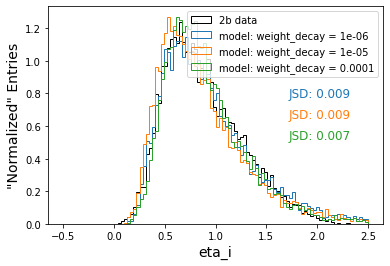

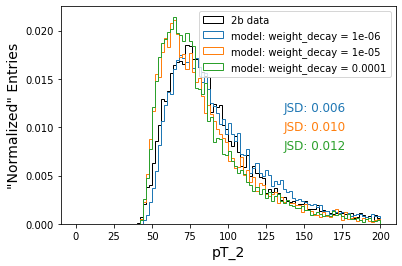

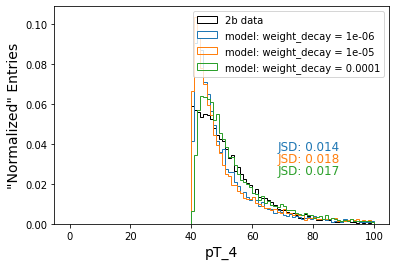

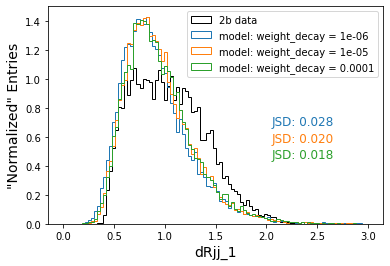

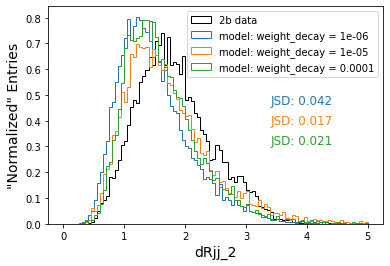

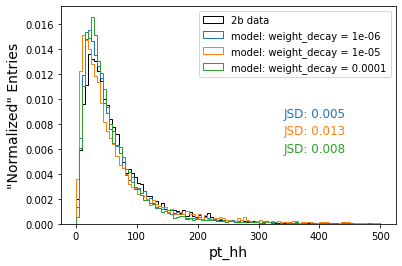

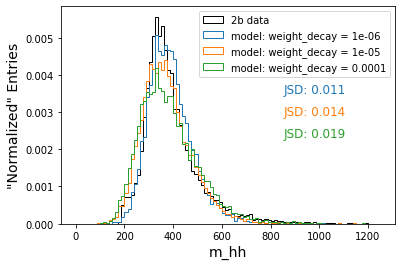

In [101]:
# Loop through the training dataset sizes and get the predictions from the generated model
ss = []
for m in L2_reg:
    s = m.model.sample(nTest).cpu().detach().numpy()
    s = m.scalarX.inverse_transform(s)

    # Since I was modelling the log of these variables, I
    # need to exponentiate to get back to the real space
    s = np.exp(s)

    # Add 40 to the first pT_2 and
    for i,c in enumerate(cols):
        if (c == 'pT_2') or (c == 'pT_4'):
            s[:,i] += 40

    ss.append(s)
            
mask = (df.ntag==2) & (df.kinematic_region==2)
for i,c in enumerate(cols):

    plt.figure()

    # Put the 2b data on the plot
    p0,_,_ = plt.hist(df.loc[mask,c].values[nTest:2*nTest],
                      100,myRanges[c],histtype='step',color='k',
                      label='2b data', density=True)

    xmax, ymax = plt.xlim()[1], plt.ylim()[1]
    
    # Put the trained models on the plot
    for s,color,weight_decay,yrel in zip(ss,['C0','C1','C2'],betas,[.6,.5,.4,.3]):
        p1,_,_ = plt.hist(s[:,i],100,myRanges[c],histtype='step',color=color,
                        label=f'model: weight_decay = {weight_decay}', density=True)

        # Calc the JSD
        m = 0.5 * (p1 + p0)
        JS = 0.5 * (entropy(p1,m) + entropy(p0,m))
    
        text = 'JSD: {:.3f}'.format(JS)
        plt.text(0.65*xmax,yrel*ymax,text,fontsize=12,color=color)

    plt.xlabel(c,fontsize=14)
    plt.ylabel('"Normalized" Entries',fontsize=14)
    plt.legend()
    #plt.title('Test set')

# Save the figure

plt.show()

### Fewer features

I'm going to see how good the modeling is just in 2d with the hh variables $p_T^{hh}$ and $m_{hh}$


In [ ]:
nTest = 10000
nEpochs = 2

In [22]:
hh = myMAF(['pt_hh','m_hh'],nTest)
hh.train(nEpochs)

fullmassplane
Taking the log of ['pt_hh', 'm_hh']




  0%|          | 0/32 [00:00<?, ?it/s]

Train, Log likelihood in nats: -724.941650: : 256it [00:00, 5453.93it/s]

Train, Log likelihood in nats: -735.287659: : 512it [00:00, 6167.83it/s]

Train, Log likelihood in nats: -735.287659: : 768it [00:00, 6507.07it/s]

Train, Log likelihood in nats: -742.470276: : 768it [00:00, 6507.07it/s]

Train, Log likelihood in nats: -733.124252: : 1024it [00:00, 6507.07it/s]

20000

Epoch: 0




Train, Log likelihood in nats: -735.761426: : 1280it [00:00, 6507.07it/s]

Train, Log likelihood in nats: -735.761426: : 1536it [00:00, 6727.91it/s]

Train, Log likelihood in nats: -732.982544: : 1536it [00:00, 6727.91it/s]

Train, Log likelihood in nats: -731.585911: : 1792it [00:00, 6727.91it/s]

Train, Log likelihood in nats: -728.989708: : 2048it [00:00, 6727.91it/s]

Train, Log likelihood in nats: -728.989708: : 2304it [00:00, 6875.56it/s]

Train, Log likelihood in nats: -730.412198: : 2304it [00:00, 6875.56it/s]

Train, Log likelihood in nats: -729.111542: : 2560it [00:00, 6875.56it/s]

Train, Log likelihood in nats: -730.695396: : 2816it [00:00, 6875.56it/s]

Train, Log likelihood in nats: -730.695396: : 3072it [00:00, 6882.72it/s]

Train, Log likelihood in nats: -728.127355: : 3072it [00:00, 6882.72it/s]

Train, Log likelihood in nats: -726.697298: : 3328it [00:00, 6882.72it/s]

Train, Log likelihood in nats: -724.975542: : 3584it [00:00, 6882.72it/s]

Train, Log likelihood i

Best validation at epoch 0: Average Log Likelihood in nats: -2.8656

Epoch: 1




Train, Log likelihood in nats: -725.940786: : 1536it [00:00, 7748.27it/s]

Train, Log likelihood in nats: -725.940786: : 1792it [00:00, 7551.27it/s]

Train, Log likelihood in nats: -723.373840: : 1792it [00:00, 7551.27it/s]

Train, Log likelihood in nats: -722.164497: : 2048it [00:00, 7551.27it/s]

Train, Log likelihood in nats: -721.648593: : 2304it [00:00, 7551.27it/s]

Train, Log likelihood in nats: -721.648593: : 2560it [00:00, 7563.27it/s]

Train, Log likelihood in nats: -724.369696: : 2560it [00:00, 7563.27it/s]

Train, Log likelihood in nats: -723.124972: : 2816it [00:00, 7563.27it/s]

Train, Log likelihood in nats: -724.848852: : 3072it [00:00, 7563.27it/s]

Train, Log likelihood in nats: -722.570298: : 3328it [00:00, 7563.27it/s]

Train, Log likelihood in nats: -722.570298: : 3584it [00:00, 7602.36it/s]

Train, Log likelihood in nats: -721.026306: : 3584it [00:00, 7602.36it/s]

Train, Log likelihood in nats: -721.397152: : 3840it [00:00, 7602.36it/s]

Train, Log likelihood i

Best validation at epoch 0: Average Log Likelihood in nats: -2.8656


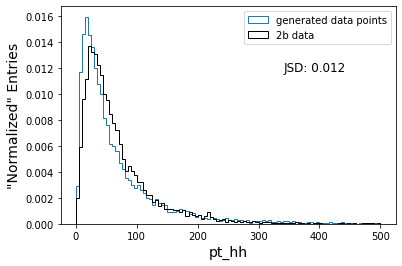

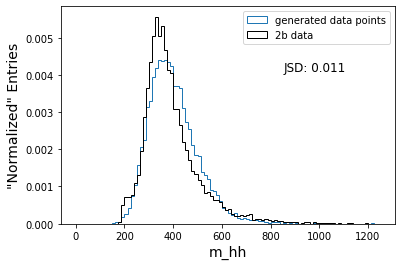

In [28]:
s = hh.model.sample(nTest).cpu().detach().numpy()
s = hh.scalarX.inverse_transform(s)

# Since I was modelling the log of these variables, I
# need to exponentiate to get back to the real space
s = np.exp(s)

mask = (df.ntag==2) & (df.kinematic_region==2)
for i,c in enumerate(['pt_hh','m_hh']):

    plt.figure()

    p, edg, _ = plt.hist([df.loc[mask,c].values[nTest:2*nTest],s[:,i]],
                         100,myRanges[c],histtype='step',color=['k','C0'],
                         label=['2b data','generated data points'], density=True)

    m = 0.5 * (p[1] + p[0])
    JS = 0.5 * (entropy(p[1],m) + entropy(p[0],m))

    xmax, ymax = plt.xlim()[1], plt.ylim()[1]

    plt.text(0.65*xmax,0.7*ymax,'JSD: {:.3f}'.format(JS),fontsize=12)

    plt.xlabel(c,fontsize=14)
    plt.ylabel('"Normalized" Entries',fontsize=14)
    plt.legend()
    #plt.title('Test set')

# Save the figure
plt.show()

Honestly, at this point, I'm tempted to switch to a model that has better theoretical guarantees!